# Kernels
The following document provides our solutions for the given exercise. The code displayed here is derived from Jan Nagler; the modifications were effectuated in order to make the code more readable and understandable.

# Question 1

Based on the program developed in the lecture, implement a nonlinear Kernel classification based on SVM for polynomial kernels (poly) and for Gaussian Kernels, i.e., radial base functions (rbf). Apply the analysis to a database of your choice, using the python code as  provided (or your own). Choose (and justify in a small text paragraph) two metrics to optimize for, such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine which combo of hyperparameters maximizes each of the two scores you chose. It would be on you if you want to use GridSearch (as used in the provided code), RandomSearch, or other methods such as hyperopt. It is also on you to try other kernels of your choice. A 2-hyperparameter scan is sufficient. Of course, you are free to scan more parameters, if useful and interesting and doable for you. Do not forget to comment your choices and results in short take-home statements.

In [1]:
#### imports
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

The code was altered, in order to create a more easier way to understand what was done. We decided to go for an object oriented program way. This allowed us to create various classes, which have either data or/and behaviour with that data. The classes which need to be created are: `Data`, `Models`, `Scorer` and `Plot`.

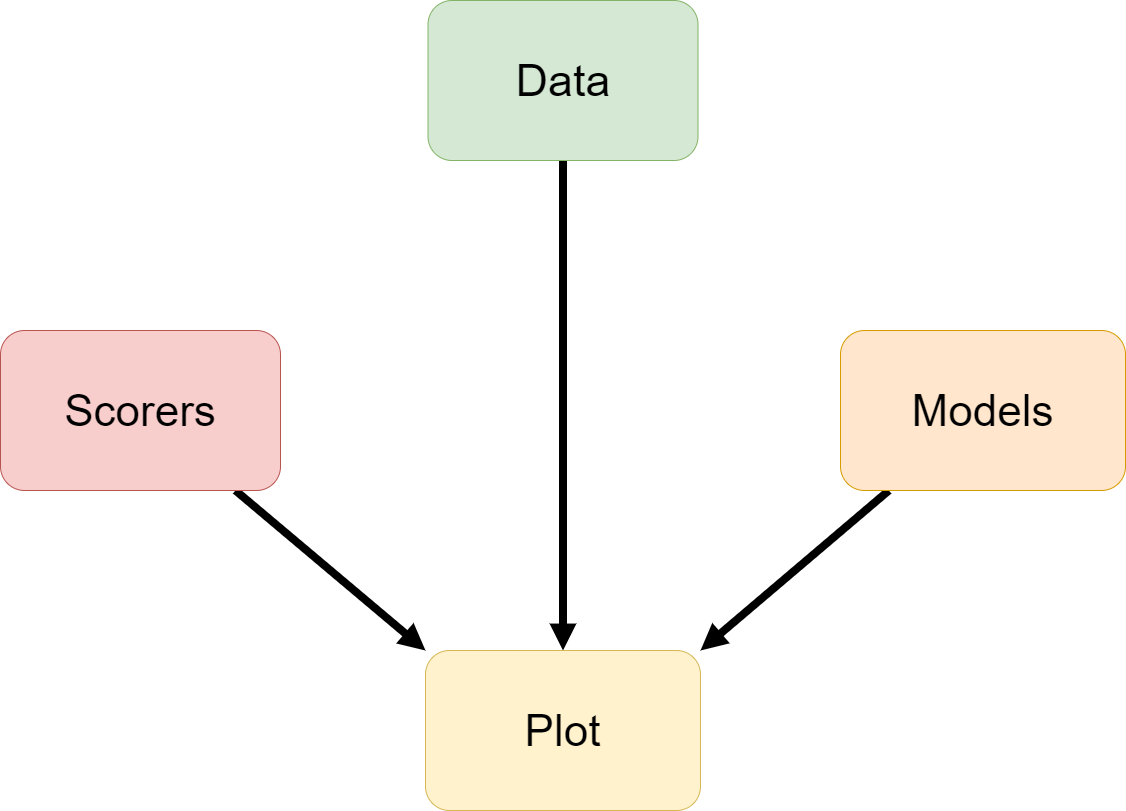

The important note here, is that `Plot` has to inherit attributes from all other three classes. How this is done, and how the classes are constructed is depicted below. This time, the docstrings are directly with the functions.

In [51]:
class Data(object):
    """Class to handle the data"""
    def __init__(self, test_size = 0.2, **kwargs):
        """Instatiates the Data class, using the penguins data from
        seaborn.
        
        Parameters
        ----------
        test_size = float
            Describes the percentage of the test size for the train
            test split        
        """
        data = sns.load_dataset('penguins').dropna().apply(LabelEncoder().fit_transform)
        self.X, self.y = data.iloc[:, :-1], data.iloc[:, -1]
#         self.X, self.y = datasets.load_breast_cancer(return_X_y = True)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size)
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        # The super() method makes sure, that when this class is inherited, to pass on
        # all not needed keyword arguments (kwargs)
        super().__init__(**kwargs)

class Models(object):
    """Class which creates the different models"""
    def __init__(self, C=1.0, kernel='poly', gamma='auto', degree = 3, num_splits = 5, **kwargs):
        """Instantiates the Models class
        
        Parameters
        ----------
        see sklearn SVC and KFold for more information
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.num_splits = num_splits
        self.degree = degree
        super().__init__(**kwargs)
    
    def SVM(self):
        """Instantiates the SVM function
        
        Returns
        -------
        SVC
            The model which can later be used
        """
        try:
            return SVC(C = self.C, kernel = self.kernel, gamma = self.gamma, degree = self.degree)
        except ValueError:
            return SVC(C = self.C, kernel = self.kernel, gamma = "auto", degree = self.degree)
    
    def KFold(self):
        """Instatiates the KFold
        
        Returns
        -------
        KFold
        """
        return KFold(self.num_splits)
        
class Scorer(object):
    """Class to create the scorers on the fly"""
    def __init__(self, beta = 0.2, **kwargs):
        self.beta = beta
        self.scorer = make_scorer(self.fbeta, greater_is_better = True)
        super().__init__(**kwargs)
        
    def fbeta(self, y_true, y_pred):
        """Instantiates the fbeta scorer, which can be altered with different
        beta values."""
        return fbeta_score(np.array(y_true), np.array(y_pred), beta = self.beta,
                           pos_label = 0 , average = "binary")

class Plot(Data, Models, Scorer):
    """Class to create plots, which inherits from Data, Models and Scorer"""
    def __init__(self, **kwargs):
        # The next line initializes the inherited classes
        super().__init__(**kwargs)
    
    def plot(self, param_name):
        """Plot the calculated validation_curve"""
        train_scores, valid_scores = validation_curve(self.SVM(), self.X_train, self.y_train, 
                                                      param_name = param_name, param_range = getattr(self, param_name),
                                                      cv=self.KFold(), scoring = self.scorer)
        plt.plot(getattr(self, param_name), train_scores.mean(axis=1), label = 'Training')
        plt.plot(getattr(self, param_name), valid_scores.mean(axis=1), label = 'Test')
        plt.xlabel(param_name)
        plt.ylabel(f'f{self.beta}')
#         plt.ylim([0,1])
        plt.title('SVM')
        plt.legend()

Here are the different plots, how good/bad the SVMs perfom.

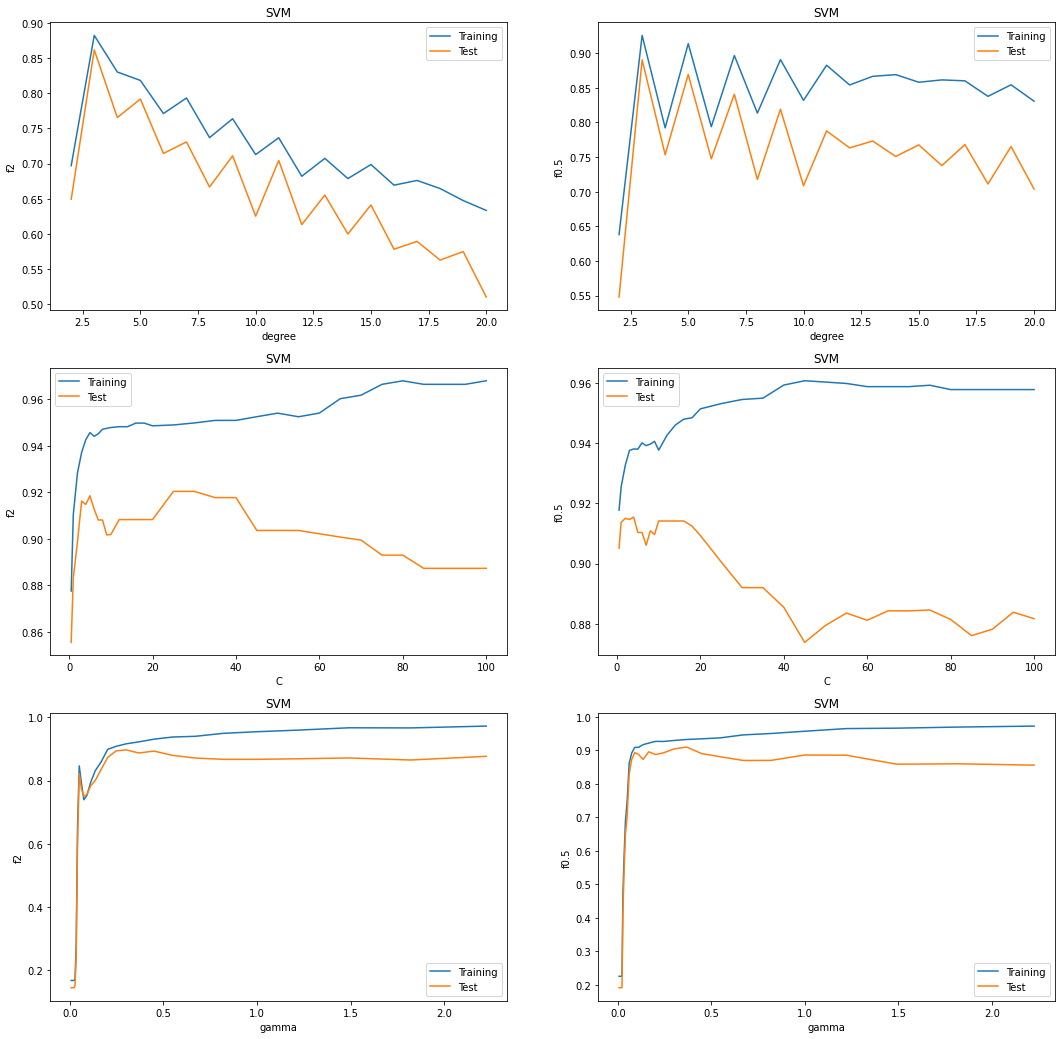

In [52]:
plt.figure(figsize = (18, 18))
plt.subplot(3, 2, 1)
Plot(degree = np.arange(2, 21, 1), beta = 2).plot("degree")
plt.subplot(3, 2, 2)
Plot(degree = np.arange(2, 21, 1), beta = 0.5).plot("degree")
plt.subplot(3, 2, 3)
Plot(C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 2).plot("C")
plt.subplot(3, 2, 4)
Plot(C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 0.5).plot("C")
plt.subplot(3, 2, 5)
Plot(gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 2).plot("gamma")
plt.subplot(3, 2, 6)
Plot(gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 0.5).plot("gamma")

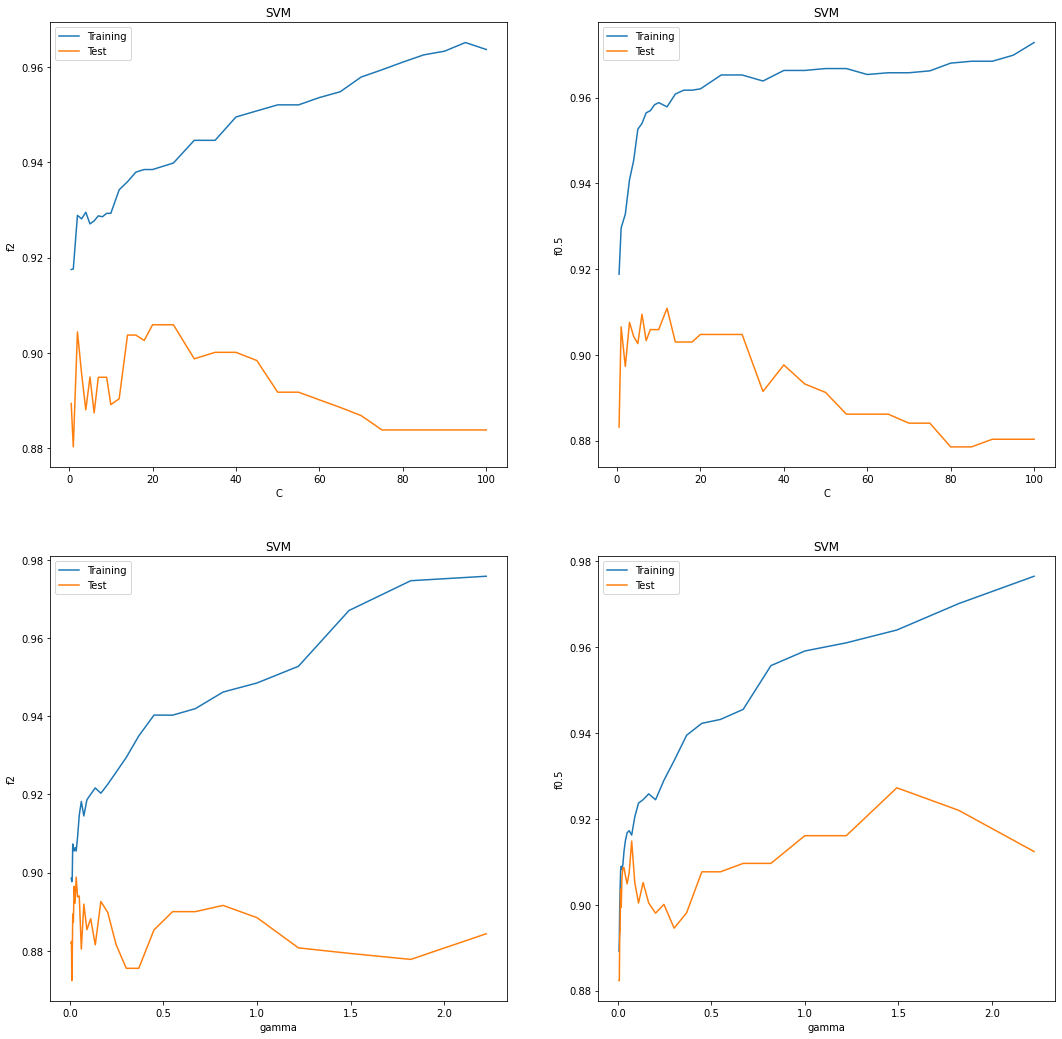

In [67]:
plt.figure(figsize = (18, 18))
plt.subplot(2, 2, 1)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 2).plot("C")
plt.subplot(2, 2, 2)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = 0.5).plot("C")
plt.subplot(2, 2, 3)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 2).plot("gamma")
plt.subplot(2, 2, 4)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = 0.5).plot("gamma")

## Metrics

In order to asses the performance of a classifier, it is important to incorporate a numerical evaluation of the algorithm. For this, a variety of performance measures are available. It is essential to make use of an adequate performance measure as their applicability and significance depend on the dataset as well as the specific classification task. In the following, the performance measures *accuracy*, *precision*, *recall*, $f_1$ *score* and $f_\beta$ *score* are explained. The end of this chapter includes our reasoning for the performance measures used during the classification task at hand.

### Accuracy

$\begin{equation} Accuracy = \frac{True Positives + True Negatives }{True Positives + Fales Positives + True Negatives + Fales Negatives} \end{equation}$

*Accuracy* measures the performance of a classification model as the number of correct predictions divided by the total number of predictions. Its main advantage is its easy interpretability. Nevertheless, *accuracy* should only be used for balanced datasets. When dealing with imbalanced datasets, i.e. when some classes are much more frequent than others, *accuracy* is not a reliable performance measure.

### Precision

$\begin{equation} Precision = \frac{True Positives}{True Positives + Fales Positives} \end{equation}$

*Precision* represents the frequency with which predictions are correct. It is also referred to *Positive Predictive Value (PPV)* or *True Positive Accuracy (TPA)*. Precision can be understood as the capability of a classifier not to label negative samples as positive.


### Recall

$\begin{equation} Recall = \frac{True Positives}{True Positives + Fales Negatives} \end{equation}$

*Recall* represents the frequency with which relevant elements are retrieved by a system.
It also referred to as *True Positive Rate (TPR)* or *Sensitivity*. Recall can be understood as the capability of a classify not to label positive samples as negative.

### Precision/Recall Trade-off

In an ideal world, precision and recall could always be increased at the same time. Unfortunately, this is not possible. This problem is referred to as the *precision/recall trade-off*. Therefore, it is important to consider what is more important for the classification task at hand.  

In some scenarios, it is reasonable to focus on precision. One example is the classification of movies for children. For a classifier detecting movies that are safe for kids, it is important that the classifier does not label negative samples, i.e. movies for adults, as positive (high precision*). As such, the classifier may also reject adequate movies for kids (low recall), but prevents violent or scary movies being promoted to children.  

In other scenarios, focusing on recall may be more suitable. One example is the application of a classifier used for cancer detection. You may wish to avoid fales negatives, i.e. predictions that someone does not have a cancer while in fact he is suffering from cancer. The objective is to be more confident of predicting benign cancer more precisely.

### $f_1$ Score

$\begin{equation} f_1 = 2 * \frac{Precision * Recall}{Precision + Recall} \end{equation}$

The $f_1$ Score is the harmonic mean of *precision* and *recall*, i.e. it applys equal weight to both.

### $f_\beta$ Score

$\begin{equation} f_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}} \end{equation}$

The $f_\beta$ Score allows for variations of the $f_1$ Score. The $\beta$ parameter determines the weight of recall in the combined score. 
- $\beta$ < 1 lends more weight to precision, 
- $\beta$ > 1 favors recall, 
- $\beta$ = 0 consider only precision, 
- $\beta$ = +$\infty$ consider only recall.  

Relevant Information Sources:  
- Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurelion Geron (2019)
- Juyper Notebook by Jan Nagler: Kernel_v6 (2021)
- Slides Machine Learning 1 by Gregory Wheeler (2021)
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

### Applied Performance Metric for this Classification Task

For the classification task at hand, we chose *accuracy* and the $f_1$ *score* as performance metrics. The dataset is fairly balanced, which in turn means that *accuracy* is a reliable performance metric. Furthermore, predicting the sex of penguins does not require a special focus on either *precision* or *recall*. The missclassification of a positive example as negative and vice verca is of equal cost. As such, we chose the $f_1$ *score* as it applies equal weight to both *precision* and *recall*.

# Polynomial Kernel

$\begin{equation} K(a, b) = (\gamma * a^T * b + r) ^d \end{equation}$  

Where:
- a, b: *a* and *b* are vectors, which refer to two different observations in the dataset.
- $\gamma$: <span style="color:red">STILL UNCLEAR!!!! Is it the same to RBF?!</span>
- r: *r* determines the coefficient of the polynomial.
- d: *d* is the degree of the polynomial kernel function.

Source:  Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurelion Geron (2019), p.171

## Relevant Hyperparameters

### Degree of the Polynomial Kernel Function: *d*

The parameter *d* is represented be the hyperparameter ```degree``` in scikit-learns *SVC*. This hyperparameter determines the degree of the polynomial kernel function. Its default value is 3. In the case of overfitting, reducing the polynomial degree may help improve the performance of the model. Conversely, in the case of underfitting, increasing the polynomial degree may help.

### Regularization Parameter C

The parameter *C* behaves as a regularization parameter in Support Vector Machines. It is represented by ```C``` in scikit-learns *SVC* with a default value of 0. "The parameter trades off the correct classification of training examples against the maximization of the decision function's margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy." It follows that in the case of overfitting, reducing the C may help improve the performance of the model. When experiencing underfitting, increasing the C may help.

### Regularization Parameter $\gamma$

$\gamma$ acts like a regularization hyperparameter. In the case of overfitting, $\gamma$ should be reduced, in the case of underfitting, $\gamma$ should be increased. In scikit-learns *SVC*, $\gamma$ is represented by the hyperparameter ```gamma```. It can be initialized to *scale*, *auto* or to a float. Its default is equal to *scale*. 

If ```gamma```is set to *scale*, then the algorithm uses $\frac{1} {n\_features * X.var())}$.  
If ```gamma```is set to *auto*, then the algorithm uses $\frac{1} {n\_features}$.

"Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors." It follows that the risk of overfitting increases with an increase in $\gamma$.

### Coefficient of the Polynomial: *r*

The parameter *r* is represented be the hyperparameter ```coef0``` in scikit-learns *SVC*. This hyperparameter controls how much the model is influenced by high-degree polynomials versus low-degree polynomials. Its default value is 0.

Sources:  
- Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurelion Geron (2019), p.158
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# Sigmoid Kernel

$\begin{equation} K(a, b) = tanh(\gamma * a^T * b + r) \end{equation}$  

Where:
- a, b: *a* and *b* are vectors, which refer to two different observations in the dataset.
- $\gamma$: <span style="color:red">STILL UNCLEAR!!!! Is it the same to RBF?!</span>
- r: *r* determines the coefficient of the polynomial.

Source:  Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurelion Geron (2019), p.171

## Relevant Hyperparamters

From here on onwards, we instantiated Data again, in order to only have the data.

In [54]:
# define Classes before
data = Data(test_size = 0.2)
svm = SVC()

Next we will do a gridsearch to search for the optimal parameters.

In [56]:
%%time
# running gridsearchCV

param_grid = {'kernel' : ['poly', 'rbf', 'linear', 'sigmoid'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/data.X_train.shape[1], 0.01, 0.1, 1, 10],
              'degree' : [2, 3, 4, 5, 7, 10]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1', 
           'f2' : Scorer(beta = 2).scorer,
           'f0.5' : Scorer(beta = 0.5).scorer
          }

CV_svm = GridSearchCV(estimator = svm, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(data.X_train, data.y_train)

Wall time: 5min 29s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
                         'degree': [2, 3, 4, 5, 7, 10],
                         'gamma': [0.16666666666666666, 0.01, 0.1, 1, 10],
                         'kernel': ['poly', 'rbf', 'linear', 'sigmoid']},
             refit='f2',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'f0.5': make_scorer(fbeta), 'f1': 'f1',
                      'f2': make_scorer(fbeta), 'recall': 'recall'})

In [88]:
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)

results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 

In [68]:
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,:].head(10))

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_f2,std_test_f2,mean_test_f0.5,std_test_f0.5
740,50.00,3.0,0.166667,poly,0.913277,0.045701,0.926898,0.057001,0.903704,0.050239,0.914061,0.044130,0.918427,0.056250,0.906821,0.045710
493,1.00,NaN,1.000000,rbf,0.917121,0.025841,0.923165,0.055135,0.918519,0.036289,0.919014,0.023452,0.914627,0.050718,0.916233,0.020732
192,0.01,5.0,1.000000,poly,0.898463,0.009550,0.924616,0.034847,0.874074,0.037771,0.897228,0.009803,0.913260,0.028740,0.886640,0.016228
780,50.00,5.0,0.166667,poly,0.894689,0.009687,0.924000,0.034896,0.866667,0.037771,0.893019,0.009797,0.911872,0.028740,0.881449,0.016701
729,50.00,NaN,0.100000,rbf,0.909574,0.045447,0.911054,0.038257,0.911111,0.064576,0.910368,0.046061,0.908046,0.039552,0.909896,0.055379
601,10.00,NaN,0.166667,rbf,0.909644,0.022329,0.912647,0.032773,0.911111,0.037771,0.911020,0.021964,0.907763,0.031029,0.908920,0.026872
920,100.00,7.0,0.166667,poly,0.879665,0.019423,0.924114,0.047494,0.837037,0.060178,0.875420,0.022735,0.906016,0.041134,0.862459,0.027193
900,100.00,5.0,0.166667,poly,0.890915,0.018783,0.915659,0.032730,0.866667,0.029630,0.889751,0.018300,0.905812,0.029505,0.878697,0.018768
609,10.00,NaN,0.100000,rbf,0.917121,0.030864,0.908370,0.043070,0.933333,0.027716,0.920063,0.028258,0.905456,0.044654,0.922803,0.027703
849,100.00,NaN,0.100000,rbf,0.902027,0.042222,0.911795,0.053628,0.896296,0.049135,0.903066,0.042020,0.904660,0.049964,0.897640,0.043006


In [59]:
results_sorted05 = results.sort_values('mean_test_f0.5', ascending = False)
results_sorted05.drop_duplicates(subset = results_sorted05.columns[3:], inplace = True) 

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
609,rbf,10.0,0.100000,NaN,0.917121,0.908370,0.933333,0.920063,0.905456,0.922803
845,rbf,100.0,0.010000,NaN,0.917051,0.911157,0.933333,0.920773,0.904587,0.922093
481,rbf,1.0,0.166667,NaN,0.902166,0.879670,0.940741,0.907989,0.874589,0.917898
620,poly,10.0,0.166667,3.0,0.913277,0.910839,0.925926,0.916565,0.903212,0.916804
493,rbf,1.0,1.000000,NaN,0.917121,0.923165,0.918519,0.919014,0.914627,0.916233
748,poly,50.0,0.100000,3.0,0.909504,0.904862,0.925926,0.913307,0.896752,0.914720
725,rbf,50.0,0.010000,NaN,0.909574,0.902540,0.925926,0.913282,0.897380,0.914061
373,rbf,0.5,1.000000,NaN,0.905800,0.898405,0.925926,0.909776,0.890421,0.913523
729,rbf,50.0,0.100000,NaN,0.909574,0.911054,0.911111,0.910368,0.908046,0.909896
489,rbf,1.0,0.100000,NaN,0.902096,0.890213,0.925926,0.906914,0.884568,0.909397


In [60]:
%%time
# other grid search with different parameters
C2 = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/Data().X_train.shape[1])}   

svm_2 = SVC(kernel = 'rbf', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = scoring, refit = 'f2')
CV_svm2.fit(data.X_train, data.y_train)

Wall time: 30 s


GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': array([  0.5,   1. ,   2. ,   3. ,   4. ,   5. ,   6. ,   7. ,   8. ,
         9. ,  10. ,  12. ,  14. ,  16. ,  18. ,  20. ,  25. ,  30. ,
        35. ,  40. ,  45. ,  50. ,  55. ,  60. ,  65. ,  70. ,  75. ,
        80. ,  85. ,  90. ,  95. , 100. ]),
                         'gamma': array([0.008     , 0.01      , 0.012     , 0.014     , 0.016     ,
       0.018     , 0.02      , 0.022     , 0.024     , 0.026     ,
       0.028     , 0.03      , 0.032     , 0.034     , 0.036     ,
       0.038     , 0.04      , 0.042     , 0.044     , 0.046     ,
       0.048     , 0.05      , 0.16666667])},
             refit='f2',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'f0.5': make_scorer(fbeta), 'f1': 'f1',
                      'f2': make_scorer(fbeta), 'recall': 'recall'})

In [61]:
# a DataFrame to keep track of the results
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_2] for k in params_2[0]}

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]

results2 = pd.DataFrame(result2)
results2.loc[:, 'kernel'] = 'rbf'
results_all = results.append(results2, ignore_index = True)

In [62]:
# Sort all results:
results_all_sorted2 = results_all.sort_values('mean_test_f2', ascending = False).reset_index(drop = True)
results_all_sorted05 = results_all.sort_values('mean_test_f0.5', ascending = False).reset_index(drop = True)

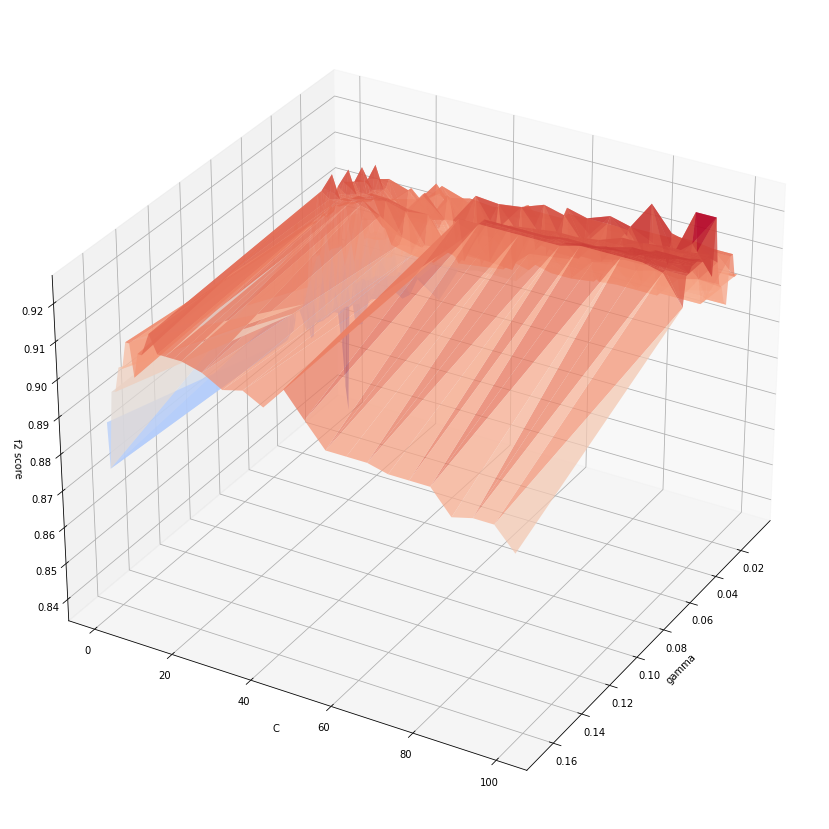

In [66]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results2.gamma, results2.C, results2.mean_test_f2, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f2 score')
ax.view_init(azim=30)    # rotation
plt.show()

In [64]:
# We use the best one for f2:
print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = SVC(C = results_all_sorted2.loc[0, 'C'], 
                     gamma = results_all_sorted2.loc[0, 'gamma'],
                     kernel = results_all_sorted2.loc[0, 'kernel'])
                     #random_state = 0)
svm_bestf2.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf2.predict(data.X_train)
y_test_pred = svm_bestf2.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

f2_train = Scorer(beta = 2).fbeta(data.y_train, y_train_pred)
f2_test = Scorer(beta = 2).fbeta(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of training sample: ', f2_train)
print('f2 score of test sample: ', f2_test)

C          85.0
gamma     0.028
kernel      rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[121  10]
 [  7 128]]
Confusion matrix of test sample: 
 [[33  1]
 [ 3 30]]
f2 score of training sample:  0.9279141104294478
f2 score of test sample:  0.9593023255813954


In [65]:
# We use the best one for f0.5:
print(results_all_sorted05.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf05 = SVC(C = results_all_sorted05.loc[0, 'C'], 
                      gamma = results_all_sorted05.loc[0, 'gamma'],
                      kernel = results_all_sorted05.loc[0, 'kernel'],
                      random_state = 0)
svm_bestf05.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf05.predict(data.X_train)
y_test_pred = svm_bestf05.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

f05_train = Scorer(beta = 0.5).fbeta(data.y_train, y_train_pred)
f05_test = Scorer(beta = 0.5).fbeta(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f0.5 score of training sample: ', f05_train)
print('f0.5 score of test sample: ', f05_test)

C          95.0
gamma     0.024
kernel      rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[120  11]
 [  7 128]]
Confusion matrix of test sample: 
 [[33  1]
 [ 3 30]]
f0.5 score of training sample:  0.9389671361502347
f0.5 score of test sample:  0.9269662921348314
